In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import neural_tangents as nt
import flax.linen as nn
import sklearn.preprocessing

from neural_tangents import stax
from typing import Sequence
from jax import jit
from jax import random
import optax
import jax
import matplotlib.pyplot as plt

from src.kernels.reference_kernels import ARDKernel, NeuralNetworkGaussianProcessKernel
from src.kernels.approximate_kernels import StochasticVariationalGaussianProcessKernel
from src.mean_functions.reference_mean_functions import ConstantFunction
from src.mean_functions.approximate_mean_functions import (
    StochasticVariationalGaussianProcessMeanFunction,
    NeuralNetworkMeanFunction,
)
from src.gaussian_measures.reference_gaussian_measures import ReferenceGaussianMeasure
from src.gaussian_measures.approximate_gaussian_measures import (
    ApproximateGaussianMeasure,
)
from src.classification_models import (
    ReferenceClassificationModel,
    ApproximateClassificationModel,
)
from src.parameters.classification_models import (
    ReferenceClassificationModelParameters,
    ApproximateClassificationModelParameters,
)

from jax.config import config

config.update("jax_enable_x64", True)

# Helper Functions

In [2]:
def one_hot_encode(y, labels):
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(labels)
    return label_binarizer.transform(y)


def plot_image_probabilities(y_probabilities, x, title, number_images_to_show=9):
    total_number_of_images = y_probabilities.shape[0]
    number_images_to_show = min(number_images_to_show, total_number_of_images)
    # idx_images_to_show = jnp.linspace(
    #     0, total_number_of_images, number_images_to_show
    # ).astype(int)
    idx_images_to_show = list(
        range(total_number_of_images - number_images_to_show, total_number_of_images)
    )
    fig, ax = plt.subplots(
        number_of_classes,
        number_images_to_show,
        figsize=(1.5 * number_images_to_show, 1.5 * number_of_classes),
    )
    for i in range(number_of_classes):
        argsort_idx = jnp.argsort(y_probabilities[:, i])
        for j, idx in enumerate(idx_images_to_show):
            ax[i, j].imshow(x[argsort_idx[idx], :].reshape(28, 28))
            ax[i, j].get_xaxis().set_visible(False)
            ax[i, j].get_yaxis().set_visible(False)
            probabilities = [
                "{:0.2f}".format(x) for x in y_probabilities[argsort_idx[idx], :]
            ]
            probabilities = [
                x if k != i else "\mathbf{" + x + "}"
                for k, x in enumerate(probabilities)
            ]
            ax[i, j].set_title("$" + ", ".join(probabilities) + "$")
    plt.suptitle(title, size=30)
    plt.tight_layout()

# Data Preprocessing

In [3]:
from mnist import MNIST

mndata = MNIST("mnist_data")
mndata.gz = True
images, labels = mndata.load_training()
binary_class_labels = [0, 1, 2]
number_of_classes = len(binary_class_labels)

In [4]:
idx_labels_binary_class = [
    i for i in range(len(labels)) if labels[i] in binary_class_labels
]
binary_images = [images[idx] for idx in idx_labels_binary_class]
binary_labels = [labels[idx] for idx in idx_labels_binary_class]

In [5]:
label_dict = {}
for binary_class_label in binary_class_labels:
    label_dict[binary_class_label] = [
        idx
        for idx in range(len(binary_labels))
        if binary_labels[idx] == binary_class_label
    ]

In [6]:
SEED = 0
np.random.seed(SEED)
key = random.PRNGKey(SEED)

number_of_training_points_per_label = 50
number_of_inducing_per_label = 3
number_of_testing_points_per_label = 50

number_of_training_points = number_of_training_points_per_label * number_of_classes
number_of_inducing = number_of_inducing_per_label * number_of_classes
number_of_testing_points = number_of_testing_points_per_label * number_of_classes

y = jnp.array(binary_labels)
y = one_hot_encode(y=y, labels=binary_class_labels)

x_inducing = jnp.concatenate(
    [
        jnp.array(
            [
                binary_images[idx]
                for idx in label_dict[binary_class_label][:number_of_inducing_per_label]
            ]
        )
        for binary_class_label in binary_class_labels
    ]
)
y_inducing = jnp.concatenate(
    [
        jnp.array(
            [
                y[idx]
                for idx in label_dict[binary_class_label][:number_of_inducing_per_label]
            ]
        )
        for binary_class_label in binary_class_labels
    ]
)

x_train = jnp.concatenate(
    [
        jnp.array(
            [
                binary_images[idx]
                for idx in label_dict[binary_class_label][
                    :number_of_training_points_per_label
                ]
            ]
        )
        for binary_class_label in binary_class_labels
    ]
)
y_train = jnp.concatenate(
    [
        jnp.array(
            [
                y[idx]
                for idx in label_dict[binary_class_label][
                    :number_of_training_points_per_label
                ]
            ]
        )
        for binary_class_label in binary_class_labels
    ]
)


x_test = jnp.concatenate(
    [
        jnp.array(
            [
                binary_images[idx]
                for idx in label_dict[binary_class_label][
                    number_of_training_points : number_of_training_points
                    + number_of_testing_points
                ]
            ]
        )
        for binary_class_label in binary_class_labels
    ]
)
y_test = jnp.concatenate(
    [
        jnp.array(
            [
                y[idx]
                for idx in label_dict[binary_class_label][
                    number_of_training_points : number_of_training_points
                    + number_of_testing_points
                ]
            ]
        )
        for binary_class_label in binary_class_labels
    ]
)

# Reference Classification Model

In [7]:
ard_classification = ReferenceClassificationModel(
    x=x_inducing,
    y=y_inducing,
    gaussian_measures={
        label: ReferenceGaussianMeasure(
            x=x_inducing,
            y=y_inducing[:, i].reshape(-1),
            kernel=ARDKernel(number_of_dimensions=x_inducing.shape[1]),
            mean_function=ConstantFunction(),
        )
        for i, label in enumerate(binary_class_labels)
    },
)

In [8]:
ard_classification_parameters = ard_classification.generate_parameters(
    {
        "gaussian_measures": {
            label: ard_classification.gaussian_measures[label].generate_parameters(
                {
                    "log_observation_noise": jnp.log(2.0),
                    "mean_function": {"constant": 0},
                    "kernel": {
                        "log_scaling": jnp.log(1.0),
                        "log_lengthscales": jnp.log(
                            1e-7 * jnp.ones(x_inducing.shape[1])
                        ).reshape(-1),
                    },
                }
            )
            for label in binary_class_labels
        }
    }
)

## Untrained Visualisations

### Inducing Set

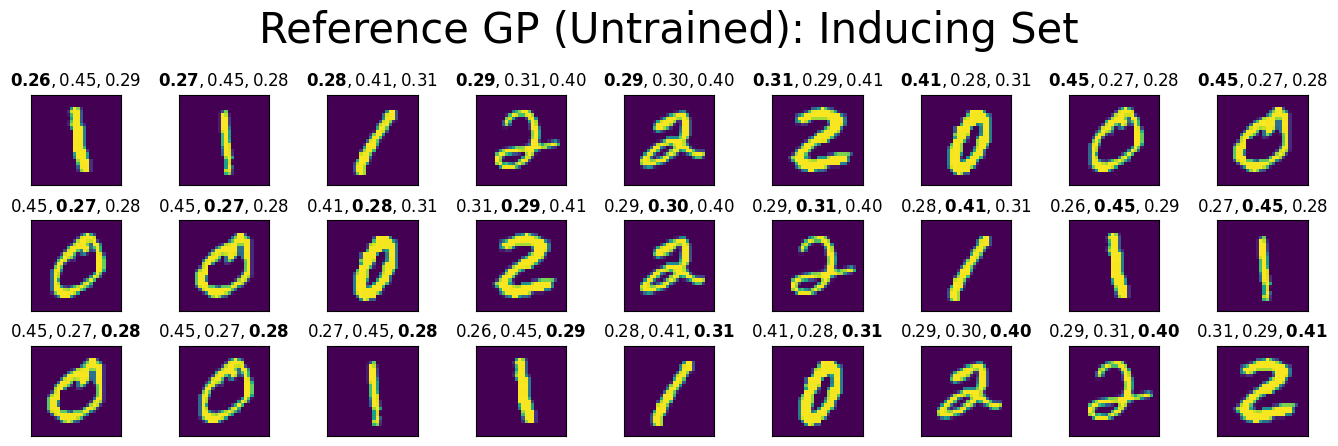

In [9]:
y_probabilities = ard_classification.predict_probability(
    parameters=ard_classification_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities, x=x_inducing, title="Reference GP (Untrained): Inducing Set"
)

### Test Set

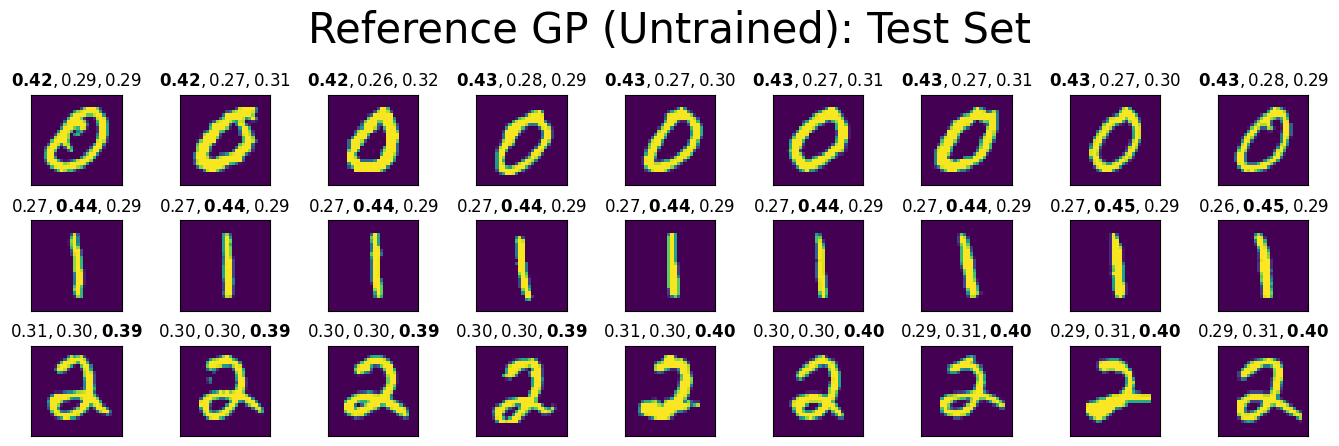

In [10]:
y_probabilities = ard_classification.predict_probability(
    parameters=ard_classification_parameters, x=x_test
)
plot_image_probabilities(
    y_probabilities, x=x_test, title="Reference GP (Untrained): Test Set"
)

## Log Likelihood Training

In [11]:
learning_rate = 5e-2
optimizer = optax.adam(learning_rate)
number_of_iterations = 100
losses = []
opt_state = optimizer.init(ard_classification_parameters.dict())
losses.append(
    ard_classification.compute_negative_log_likelihood(
        parameters=ard_classification_parameters,
        x=x_inducing,
        y=y_inducing,
    )
)

In [12]:
for _ in range(number_of_iterations):
    gradients = jax.grad(
        lambda ard_classification_parameters_dict: ard_classification.compute_negative_log_likelihood(
            parameters=ard_classification_parameters_dict,
            x=x_inducing,
            y=y_inducing,
        )
    )(ard_classification_parameters.dict())
    updates, opt_state = optimizer.update(gradients, opt_state)
    ard_classification_parameters = ard_classification.generate_parameters(
        optax.apply_updates(ard_classification_parameters.dict(), updates)
    )
    losses.append(
        ard_classification.compute_negative_log_likelihood(
            parameters=ard_classification_parameters,
            x=x_inducing,
            y=y_inducing,
        )
    )

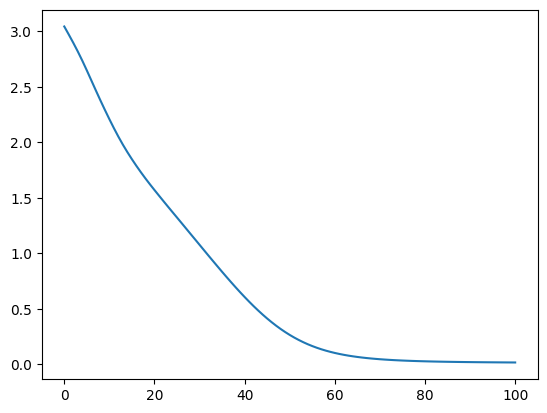

In [13]:
plt.plot(losses)

## Trained Visualisations

### Inducing Set

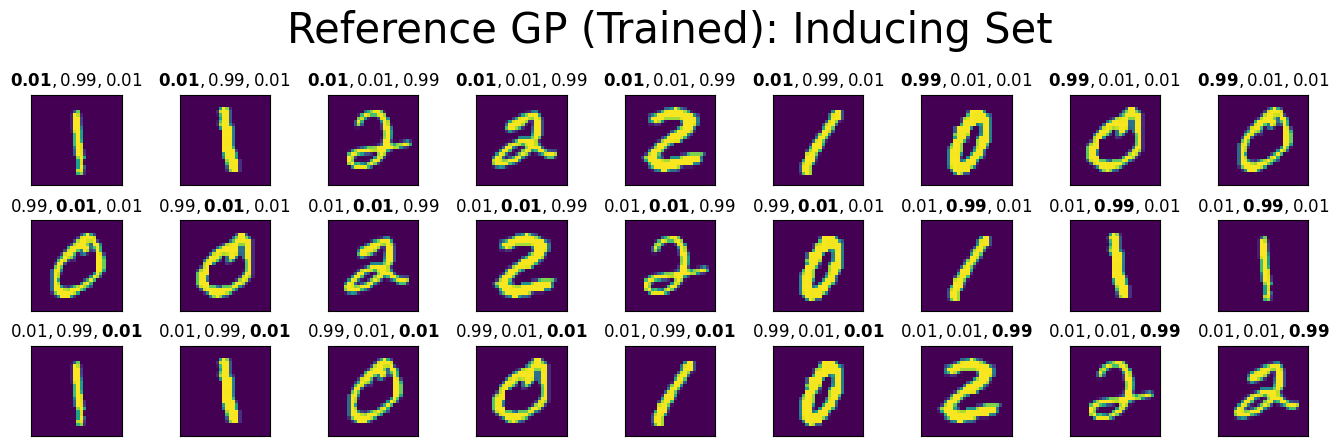

In [14]:
y_probabilities = ard_classification.predict_probability(
    parameters=ard_classification_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities, x=x_inducing, title="Reference GP (Trained): Inducing Set"
)

### Test Set

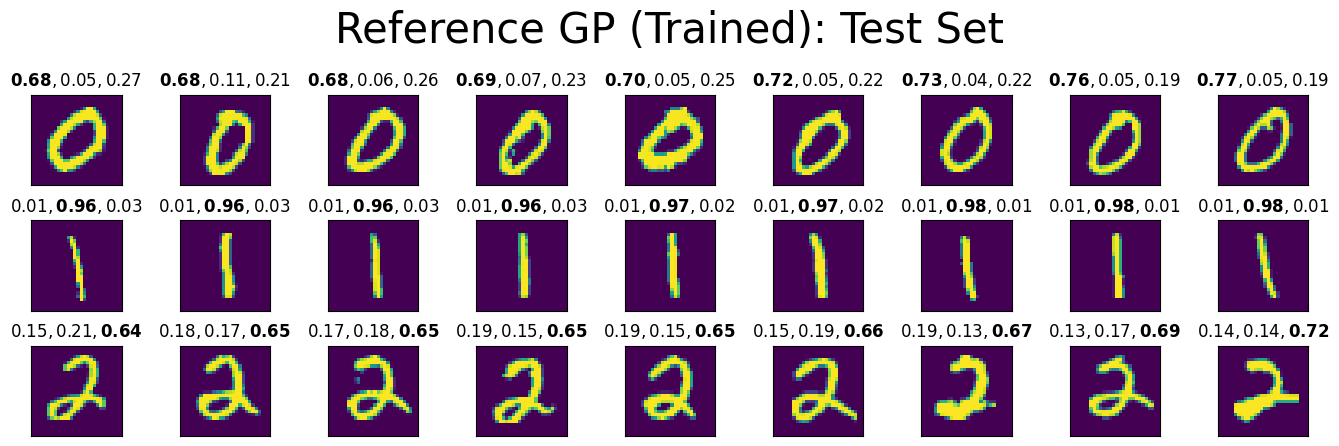

In [15]:
y_probabilities = ard_classification.predict_probability(
    parameters=ard_classification_parameters, x=x_test
)
plot_image_probabilities(
    y_probabilities, x=x_test, title="Reference GP (Trained): Test Set"
)

## Lengthscale Visualisation

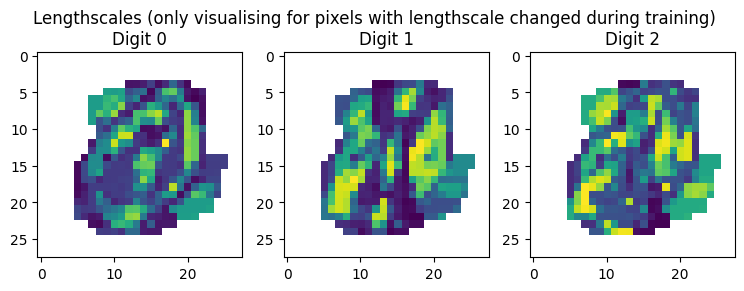

In [16]:
fig, ax = plt.subplots(
    1,
    number_of_classes,
    figsize=(3 * number_of_classes, 3),
)
for i, label in enumerate(ard_classification.labels):
    lengthscales = jnp.exp(
        ard_classification_parameters.gaussian_measures[
            label
        ].kernel.log_lengthscales.reshape(28, 28)
    )
    lengthscales = np.array(lengthscales)
    lengthscales[abs(lengthscales - 1e-7) < 1e-12] = np.nan
    ax[i].imshow(jnp.log(lengthscales))
    ax[i].set_title(f"Digit {label}")
plt.suptitle(
    f"Lengthscales (only visualising for pixels with lengthscale changed during training)"
)
plt.show()

# Approximate Classification Model

In [17]:
approximate_classification_model = ApproximateClassificationModel(
    x=x_train,
    y=y_train,
    gaussian_measures={
        label: ApproximateGaussianMeasure(
            x=ard_classification.gaussian_measures[label].x,
            y=ard_classification.gaussian_measures[label].y,
            kernel=StochasticVariationalGaussianProcessKernel(
                reference_gaussian_measure_parameters=ard_classification_parameters.gaussian_measures[
                    label
                ],
                reference_kernel=ard_classification.gaussian_measures[label].kernel,
                inducing_points=ard_classification.gaussian_measures[label].x,
                training_points=x_train,
            ),
            mean_function=StochasticVariationalGaussianProcessMeanFunction(
                reference_gaussian_measure_parameters=ard_classification_parameters.gaussian_measures[
                    label
                ],
                reference_mean_function=ard_classification.gaussian_measures[
                    label
                ].mean_function,
                reference_kernel=ard_classification.gaussian_measures[label].kernel,
                inducing_points=ard_classification.gaussian_measures[label].x,
            ),
            reference_gaussian_measure=ard_classification.gaussian_measures[label],
            reference_gaussian_measure_parameters=ard_classification_parameters.gaussian_measures[
                label
            ],
        )
        for label in ard_classification.labels
    },
    reference_classification_model=ard_classification,
    reference_classification_model_parameters=ard_classification_parameters,
)

In [18]:
key, subkey = random.split(key)
approximate_classification_model_parameters = (
    approximate_classification_model.generate_parameters(
        {
            "gaussian_measures": {
                label: {
                    "mean_function": approximate_classification_model.gaussian_measures[
                        label
                    ].mean_function.initialise_random_parameters(subkey),
                    "kernel": {},
                }
                for label in approximate_classification_model.labels
            }
        }
    )
)

## Untrained Visualisations

### Inducing Set

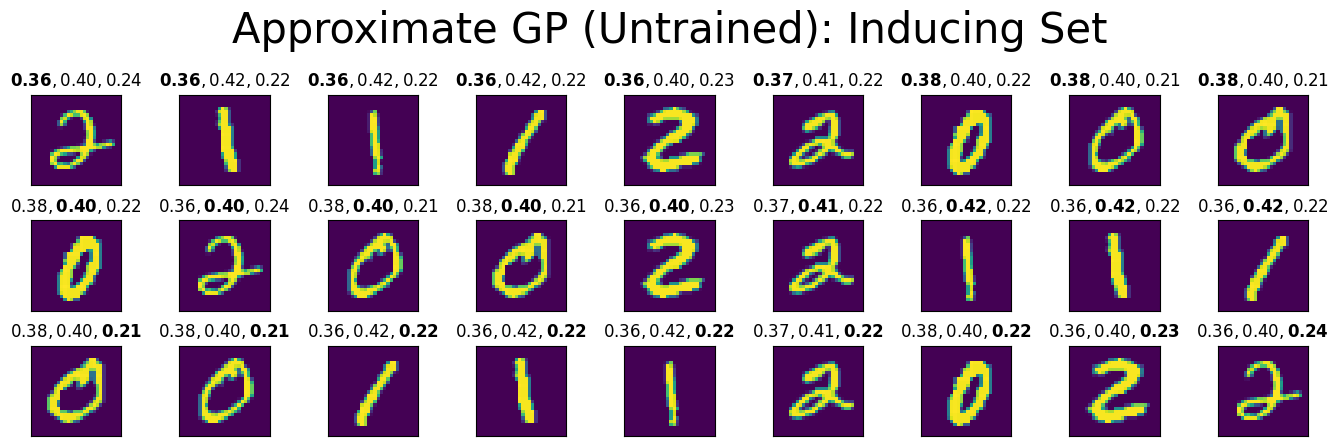

In [19]:
y_probabilities = approximate_classification_model.predict_probability(
    parameters=approximate_classification_model_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities, x=x_inducing, title="Approximate GP (Untrained): Inducing Set"
)

### Train Set

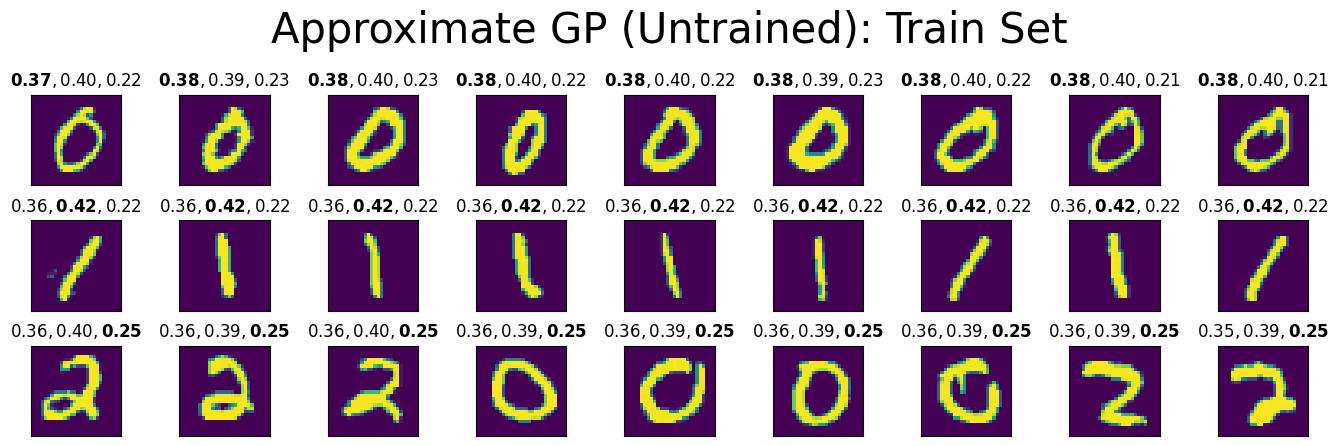

In [20]:
y_probabilities = approximate_classification_model.predict_probability(
    parameters=approximate_classification_model_parameters, x=x_train
)
plot_image_probabilities(
    y_probabilities, x=x_train, title="Approximate GP (Untrained): Train Set"
)

### Test Set

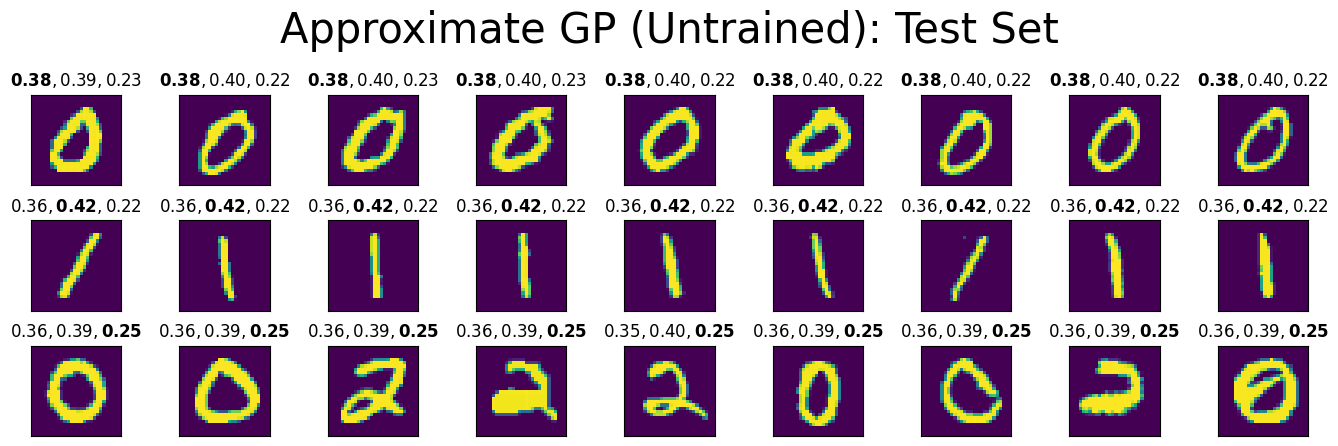

In [21]:
y_probabilities = approximate_classification_model.predict_probability(
    parameters=approximate_classification_model_parameters, x=x_test
)
plot_image_probabilities(
    y_probabilities, x=x_test, title="Approximate GP (Untrained): Test Set"
)

## GWI Training

In [22]:
learning_rate = 5e-3
optimizer = optax.adam(learning_rate)
number_of_iterations = 500
opt_state = optimizer.init(approximate_classification_model_parameters.dict())
losses = []
losses.append(
    approximate_classification_model.compute_gaussian_wasserstein_inference_loss(
        parameters=approximate_classification_model_parameters,
        x_batch=x_train,
    )
)

In [23]:
for _ in range(number_of_iterations):
    gradients = jax.grad(
        lambda approximate_classification_model_parameters_dict: approximate_classification_model.compute_gaussian_wasserstein_inference_loss(
            parameters=approximate_classification_model_parameters_dict,
            x_batch=x_train,
        )
    )(approximate_classification_model_parameters.dict())
    updates, opt_state = optimizer.update(gradients, opt_state)
    approximate_classification_model_parameters_new = (
        approximate_classification_model.generate_parameters(
            optax.apply_updates(
                approximate_classification_model_parameters.dict(), updates
            )
        )
    )
    losses.append(
        approximate_classification_model.compute_gaussian_wasserstein_inference_loss(
            parameters=approximate_classification_model_parameters_new,
            x_batch=x_train,
        )
    )
    if jnp.isnan(losses[-1]):
        break
    approximate_classification_model_parameters = (
        approximate_classification_model_parameters_new
    )

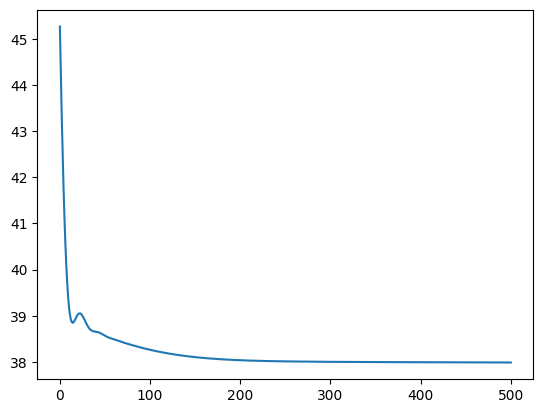

In [24]:
plt.plot(losses)

## Trained Visualisations

### Inducing Set

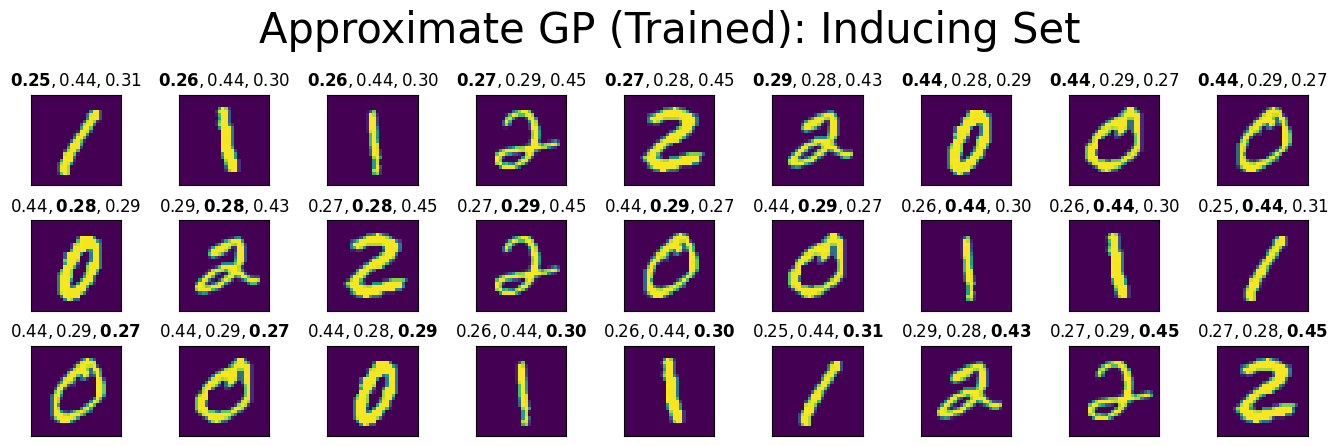

In [25]:
y_probabilities = approximate_classification_model.predict_probability(
    parameters=approximate_classification_model_parameters, x=x_inducing
)
plot_image_probabilities(
    y_probabilities, x=x_inducing, title="Approximate GP (Trained): Inducing Set"
)

### Train Set

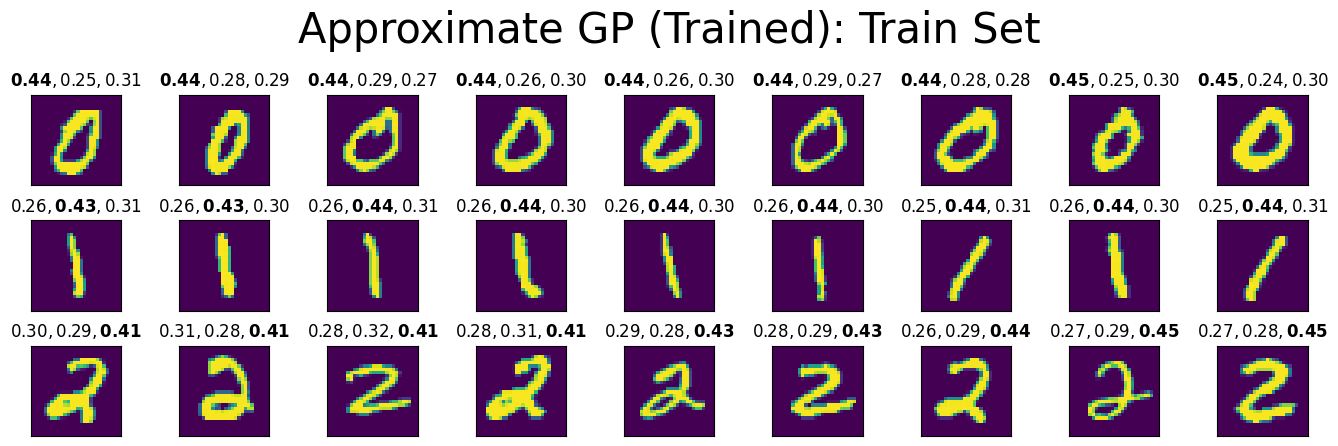

In [26]:
y_probabilities = approximate_classification_model.predict_probability(
    parameters=approximate_classification_model_parameters, x=x_train
)
plot_image_probabilities(
    y_probabilities, x=x_train, title="Approximate GP (Trained): Train Set"
)

### Test Set

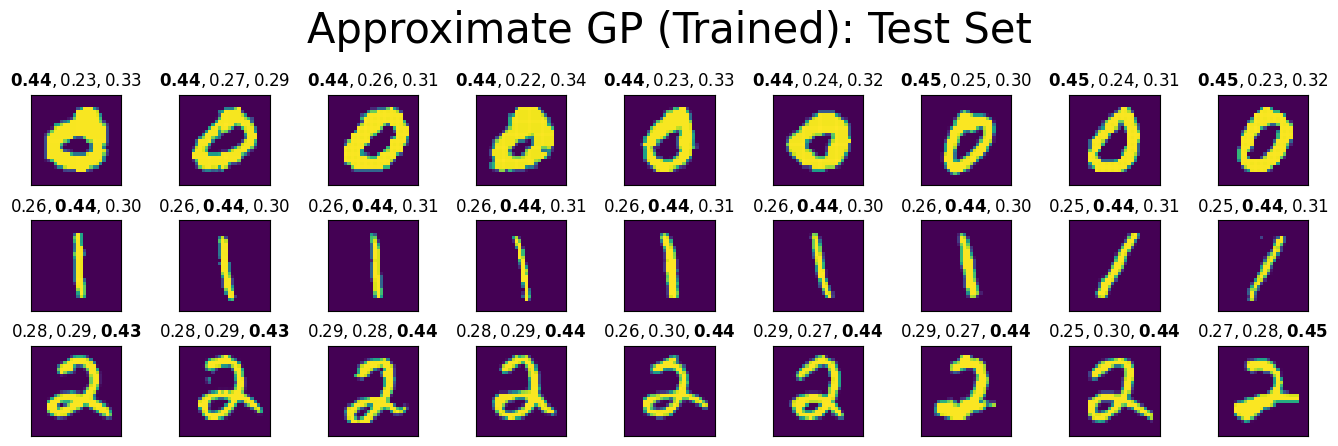

In [27]:
y_probabilities = approximate_classification_model.predict_probability(
    parameters=approximate_classification_model_parameters, x=x_test
)
plot_image_probabilities(
    y_probabilities, x=x_test, title="Approximate GP (Trained): Test Set"
)